# Single Subject GLM Analysis using the Localizer dataset

In this lab, extend your work from the previous lab to work with 3D brain data. The preprocessed data of the first subject in the localizer study is included.

In [1]:
import os
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import nibabel as nib

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from sklearn.cluster import KMeans
import scipy.ndimage

Load the functional image of the first subject.

In [2]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')

We should get a sequence of 128 frames of 3D images of the shape (53, 63, 46).

In [3]:
data.get_fdata().shape

(53, 63, 46, 128)

Let's plot a few brain slices just to check if we are actually seeing some brain.

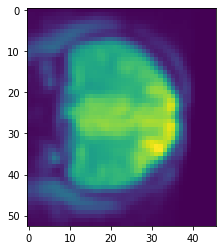

In [4]:
plt.imshow(data.get_fdata()[:,50,:,0])

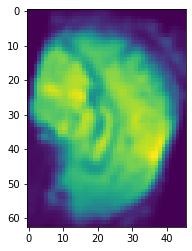

In [5]:
plt.imshow(data.get_fdata()[25,:,:,0])

Let's load the mask data for this subject.

In [6]:
mask = nib.load('./sub-S01_mask.nii.gz')

The shape of the mask data should be identical to that of a signle frame in the brain data.

In [7]:
mask.get_fdata().shape

(53, 63, 46)

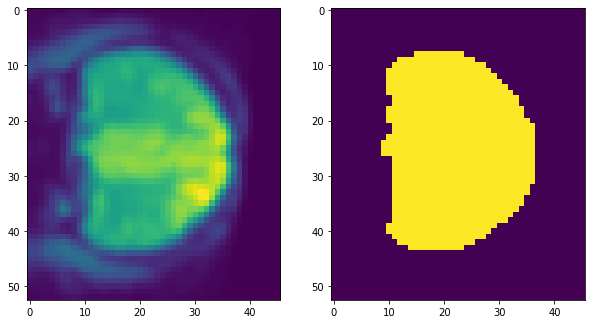

In [8]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[:,50,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[:,50,:])

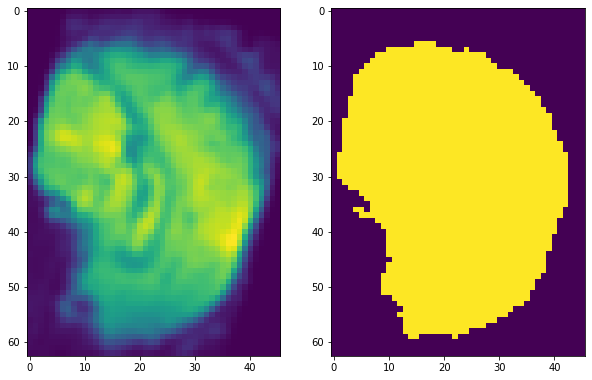

In [9]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(data.get_fdata()[25,:,:,0])
plt.subplot(1,2,2)
plt.imshow(mask.get_fdata()[25,:,:])

In [10]:
def estimate_beta(X, Y):
    return np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)

In [11]:
def compute_beta_map(data, X):
        n_regressors = X.shape[1]
        beta_map = np.zeros((data.shape[0],data.shape[1],data.shape[2],n_regressors))    
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                for k in range(data.shape[2]):
                    Y = data[i,j,k,:]
                    bs = estimate_beta(X, Y)
                    beta_map[i,j,k,:] = bs
        return beta_map

In [12]:
def compute_contrast(beta_map, contrast):    
    b = np.squeeze(beta_map)
    c = np.array(contrast).T
    cs = np.dot(b,c)   
    return cs

In [13]:
def ShowSlicesAcrossAxis(data, axis, numberOfSlices, steps):
    if axis == 'x':
        plt.figure(figsize=(30, 30))
        for i in range(numberOfSlices):
            if i*steps >= data.shape[0]:
                break
            plt.subplot(10,5,i+1)
            plt.text(5,250,'x = %d'%(i*steps),color='white')
            plt.imshow(data[i*steps,:,:])
        plt.show()
    if axis == 'y':
        plt.figure(figsize=(30, 30))
        for i in range(numberOfSlices):
            if i*steps >= data.shape[1]:
                break
            plt.subplot(10,5,i+1)
            plt.text(5,190,'y = %d'%(i*steps),color='white')
            plt.imshow(data[:,i*steps,:])
        plt.show()
    if axis == 'z':
        plt.figure(figsize=(30, 30))
        for i in range(numberOfSlices):
            if i*steps >= data.shape[2]:
                break
            plt.subplot(10,5,i+1)
            plt.text(5,190,'z = %d'%(i*steps),color='white')
            plt.imshow(data[:,:,i*steps])
        plt.show()

In [14]:
def visualize_contrast(beta_map, contrast, mask, axis, numSlices, steps):
    c = compute_contrast(beta_map, contrast)
    masked_contrast = np.multiply(c, mask)
    masked_contrast[masked_contrast == 0] = np.NINF
    
    ShowSlicesAcrossAxis(masked_contrast, axis, numSlices, steps)

In [15]:
def visualize_contrast_threshold(beta_map, contrast, mask, axis, numSlices, steps, threshold):
    c = compute_contrast(beta_map, contrast)
    
    masked_contrast = np.multiply(c, mask)
    masked_contrast[masked_contrast == 0] = np.NINF
    
    maximum = masked_contrast.max()
    
    masked_contrast[masked_contrast <= threshold*maximum] = 1
    masked_contrast[mask == 0] = np.NINF
    
    
    #Everywhere that mask is 1, c will be set to 0
    c[mask] = 0
       
    ShowSlicesAcrossAxis(masked_contrast, axis, numSlices, steps)
    
    

In [16]:
def get_contrast_thresholded(beta_map, contrast_vector, mask, threshold):
    c = compute_contrast(beta_map, contrast_vector)
    
    masked_contrast = np.multiply(c, mask)
    masked_contrast[masked_contrast == 0] = np.NINF
    
    maximum = masked_contrast.max()
    
    masked_contrast[masked_contrast <= threshold*maximum] = 1
    masked_contrast[mask == 0] = np.NINF
    masked_contrast[masked_contrast == 1] = 0
    
    return masked_contrast

In [17]:
def get_most_active_slice(data, axis):
    
    x,y,z = data.shape
    copy = data.copy()
    copy[copy == np.NINF] = 0
    
    maximum = 0
    slice_index = 0
    
    if axis == 'x':
        for i in range(x):
            summ = copy[i,:,:].sum()
            if summ > maximum:
                slice_index = i
                maximum = summ
        return slice_index
            
    if axis == 'y':
        for i in range(y):
            summ = copy[:,i,:].sum()
            if summ > maximum:
                slice_index = i
                maximum = summ
        return slice_index
        
    if axis == 'z':
        for i in range(z):
            summ = copy[:,:,i].sum()
            if summ > maximum:
                slice_index = i
                maximum = summ
        return slice_index

In [18]:
def ShowLocationWithMask(data, mask, x, y, z):
    
    x_size, y_size, z_size = data.shape
    
    fontsize = 50
    
    #x_abs, y_abs, z_abs = x+int(x_size/2), y+int(y_size/2), z+int(z_size/2)
    x_abs, y_abs, z_abs = x,y,z
    
    if x_abs >= x_size or y_abs >= y_size or z_abs >=z_size:
        print("Invalid location")
        return
    if x_abs < 0 or y_abs < 0 or z_abs < 0:
        print("Invalid location")
        return
    
    data_arr = data
    xslice = np.rot90(data_arr[x_abs,:,:],1)
    yslice = np.rot90(data_arr[:,y_abs,:],1)
    zslice = np.rot90(data_arr[:,:,-z_abs],1)
    
    mask_arr = mask
    xslice_mask = np.rot90(mask_arr[x_abs,:,:],1)
    yslice_mask = np.rot90(mask_arr[:,y_abs,:],1)
    zslice_mask = np.rot90(mask_arr[:,:,-z_abs],1)
    
    fig,ax = plt.subplots(ncols=3,sharey=True,gridspec_kw={'width_ratios': [1,y_size/x_size,1]}, figsize=(40,30))
    
    ax[1].imshow(xslice, interpolation='none')
    #ax[1].imshow(xslice_mask, 'jet', alpha=0.5, interpolation='none')
    ax[1].text(5,y_size-5,'x = %d'%(x),color='black',fontsize=fontsize)
    ax[1].axis('off')
    ax[1].axhline(z_abs,color='white',linewidth=2)
    ax[1].axvline(y_abs,color='white',linewidth=2)
    
    ax[2].imshow(zslice, interpolation='none')
    #ax[2].imshow(zslice_mask, 'jet', alpha=0.5, interpolation='none')
    ax[2].text(5,y_size-5,'z = %d'%(z),color='black',fontsize=fontsize)
    ax[2].text(5,5,'L',color='black',fontsize=fontsize)
    ax[2].text(x_size-5,5,'R',color='black',fontsize=fontsize)
    ax[2].axis('off')
    ax[2].axhline(y_abs,color='white',linewidth=2)
    ax[2].axvline(x_abs,color='white',linewidth=2)
    
    ax[0].imshow(yslice, interpolation='none')
    #ax[0].imshow(yslice_mask, 'jet', alpha=0.5, interpolation='none')
    ax[0].text(5,y_size-5,'y = %d'%(y),color='black',fontsize=fontsize)
    ax[0].text(5,5,'L',color='black',fontsize=fontsize)
    ax[0].text(x_size-5,5,'R',color='black',fontsize=fontsize)
    ax[0].axis('off')
    ax[0].axhline(z_abs,color='white',linewidth=2)
    ax[0].axvline(x_abs,color='white',linewidth=2)
    
    fig.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [19]:
visual_mask = np.array([1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0])
auditory_mask = np.array([0,0,1,1,0,0,1,0,0,1,0,0,0,0,0,0,0])
motor_mask = np.array([0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0])
cognitive_mask = np.array([0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0])
numbers_mask = np.array([0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0])
words_mask = np.array([0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0])

keyword_table = {'visual':visual_mask,
                 'auditory':auditory_mask,
                 'motor':motor_mask,
                 'cognitive':cognitive_mask,
                 'numbers':numbers_mask,
                 'words':words_mask}

def get_contrast_vector(keywords):
    return keyword_table[keywords[0]] - keyword_table[keywords[1]]
    

In [20]:
def exploreContrast(data, design_matrix, contrast_keywords, contrast_threshold, mask):
    
    print('Computing Beta Map...')
    beta_map = compute_beta_map(data, design_matrix)
    
    print('Computing Contrast for %s vs. %s'%(contrast_keywords[0],contrast_keywords[1]))
    contrast_vector = get_contrast_vector(contrast_keywords)
    
    contrast = get_contrast_thresholded(beta_map, contrast_vector, mask, contrast_threshold)
    
    
    # --- CLustering code started from Thurs ---
    
    #Making a deep copy of the contrast so I dont overwrite it (janky)
    contrast_cluster = contrast.copy()
    
    #Setting the -inf mask that displays nicely to 0 for ndimage.cluster
    contrast_cluster[contrast_cluster == np.NINF] = 0
    
    #Running ndimage on contrast copy
    labels, num_features = scipy.ndimage.label(contrast_cluster)
    
    #Degbu output
    print(num_features)
    print(labels)
    
    #Masking out everything that isn't in cluter 1 in the original contrast (will affect the visualization belpow)
    contrast[labels!=1] = np.NINF
    
    #-------------------------------------------
    
    x_lim, y_lim, z_lim = contrast.shape
    
    x_default = get_most_active_slice(contrast, 'x')
    y_default = get_most_active_slice(contrast, 'y')
    z_default = get_most_active_slice(contrast, 'z')
    
    interact_manual(ShowLocationWithMask,
                    data=fixed(contrast),
                    mask=fixed(mask),
                    x = widgets.IntSlider(min=0,max=x_lim,value=x_default), 
                    y = widgets.IntSlider(min=0,max=y_lim,value=y_default), 
                    z = widgets.IntSlider(min=0,max=z_lim,value=z_default)) 
    return

- 3D Convolution to merge nearby clusters
- Find clusters
- Find cluster centers
- Slider to explore clusters
- Offload reusable code into seperate module

In [21]:
data = nib.load('preprocessed_fMRI_bold.nii.gz')
mask = nib.load('./sub-S01_mask.nii.gz')
design_matrix = np.load('design_matrix.npy')
labels = np.load('labels.npy')

exploreContrast(data.get_fdata(), design_matrix, ['auditory','visual'], 0.1, mask.get_fdata())

Computing Beta Map...
Computing Contrast for auditory vs. visual
207
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


interactive(children=(IntSlider(value=4, description='x', max=53), IntSlider(value=25, description='y', max=63…

# Exercise 

For each of the question below, use your code to perform the analysis.

## Which regions are more involved with visual compared to auditory sensory processing?

In [22]:
visualize_contrast_threshold(beta_map, [1,1,-1,-1,1,1,-1,1,1,-1,0,0,0,0,0,0,0], mask.get_fdata(), 'z', 46, 1, 0.1)

NameError: name 'beta_map' is not defined

## Which regions are more involved in processing numbers compared to words?

In [ ]:
visualize_contrast_threshold(beta_map, [0,0,0,0,0,0,1,1,-1,-1,0,0,0,0,0,0,0], mask.get_fdata(), 'z', 20, 2, 0.1)

## Which regions are more involved with motor compared to cognitive processes (e.g., language and math)?

In [ ]:
visualize_contrast_threshold(beta_map, [0,0,1,1,1,1,-1,-1,-1,-1,0,0,0,0,0,0,0], mask.get_fdata(), 'z', 20, 2, 0.1)